In [ ]:
# Download the dataset
import kagglehub
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Replace with your dataset name
path = kagglehub.dataset_download("smagnan/1-million-reddit-comments-from-40-subreddits")
# path = "/root/.cache/kagglehub/datasets/smagnan/1-million-reddit-comments-from-40-subreddits/versions/1"

# Load CSV File (Modify file name if needed)
df = pd.read_csv(f"{path}/kaggle_RC_2019-05.csv")  # Update filename if different

# Drop scores of 1 right off the bat since these represen non-engangement comments
# df_filtered = df[df['score'] != 1]

num_samples = 20000
df = df.sample(n=num_samples, random_state=42)
print(df.shape)
print(df.head())

100%|██████████| 71.2M/71.2M [00:00<00:00, 159MB/s]

Extracting files...


(20000, 4)
             subreddit                                               body  \
987231     apexlegends  How ironic that you're being indignant on the ...   
79954   ChapoTrapHouse  I started work in 99 when the boomers we're st...   
567130        Market76  Any combination of the following:\n\nAAE Pump ...   
500891       worldnews  Compare pharma's marketing budget to it's R&am...   
55399        worldnews                Wasn't it an illegitimate election?   

        controversiality  score  
987231                 0      0  
79954                  0      2  
567130                 0      1  
500891                 0      1  
55399                  0      2  


In [ ]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract text from "body" field and preprocess
comments = df["body"].dropna().astype(str).tolist()  # Convert column to list of comments

# Tokenize and collect unique words
unique_words = set()
for comment in comments:
    words = re.findall(r"\b[a-zA-Z]+\b", comment.lower())  # Extract words (no numbers/symbols)
    unique_words.update(words)  # Add words to set to ensure uniqueness

# Convert set to sorted list (optional)
custom_vocab = sorted(unique_words)

print("Vocabulary Size:", len(custom_vocab))  # Number of unique words
print("Sample Vocabulary:", custom_vocab[:10])  # Preview some words


Vocabulary Size: 26307
Sample Vocabulary: ['a', 'aa', 'aaa', 'aaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaand', 'aaaaaaall', 'aaaaaah', 'aaaaand', 'aaaannd']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TF-IDF Vectorizer using custom vocabulary
vectorizer = TfidfVectorizer(vocabulary=custom_vocab, stop_words="english")

# Fit and transform the comments
tfidf_matrix = vectorizer.fit_transform(df["body"].astype(str))  # Convert to string in case of NaNs

# Convert to DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display sample embeddings
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print(tfidf_df.head())



TF-IDF Matrix Shape: (20000, 26307)
     a   aa  aaa  aaaaa  \
0  0.0  0.0  0.0    0.0   
1  0.0  0.0  0.0    0.0   
2  0.0  0.0  0.0    0.0   
3  0.0  0.0  0.0    0.0   
4  0.0  0.0  0.0    0.0   

   aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa  \
0                                                0.0                            
1                                                0.0                            
2                                                0.0                            
3                                                0.0                            
4                                                0.0                            

   aaaaaaaaaaaaaaand  aaaaaaall  aaaaaah  aaaaand  aaaannd  ...   zu  zucc  \
0                0.0        0.0      0.0      0.0      0.0  ...  0.0   0.0   
1                0.0        0.0      0.0      0.0      0.0  ...  0.0   0.0   
2                0.0        0.0      0.0      0.0      0.0  ...  0.0   0.0   
3 

10.83435


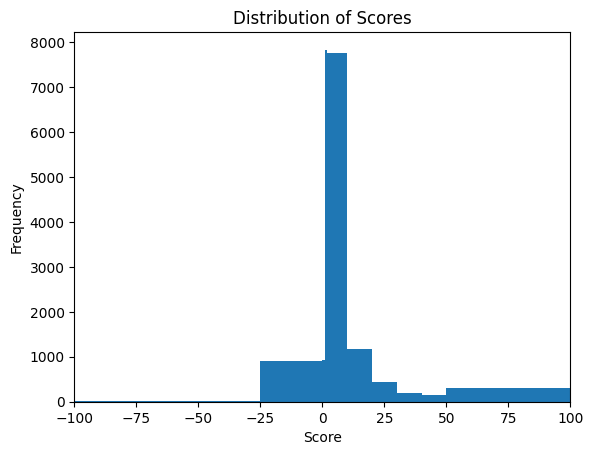

In [ ]:
import matplotlib.pyplot as plt

average_score = df['score'].mean()
print(average_score)

plt.hist(df['score'], bins=[-100, -50, -25, 0, 1, 2, 10, 20, 30, 40, 50, 100])  # Adjust 'bins' for desired granularity
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

plt.xlim(-100, 100)
plt.show()

In [ ]:
below_1 = (df['score'] < 1).sum()
above_1 = (df['score'] > 1).sum()
equal_1 = (df['score'] == 1).sum()
print("Below 1: ", below_1)
print("Above 1: ", above_1)
print("Equal to 1: ", equal_1)

Below 1:  1883
Above 1:  10286
Equal to 1:  7831


In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# Cut the score field into 2 bins: negative (-inf, 1) and positive (1, inf)

# df['score_category'] = pd.cut(
#                           df['score'],
#                           bins=[-float('inf'), 1, float('inf')],
#                           labels=['negative', 'positive']
#                         )

# Convert score into class labels
def convert_score(score):
    if score < 1:
        return 0  # Negative
    elif score == 1:
        return 1  # Neutral
    else:
        return 2  # Positive

df['score_category'] = df['score'].apply(convert_score)

# Convert labels to numerical data using LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['score_category'])

print("Label Encoding:")
print(labels)
print("Label Size: ", len(labels))

print("Category counts:")
print(df['score_category'].value_counts())


Label Encoding:
[0 2 1 ... 2 2 1]
Label Size:  20000
Category counts:
score_category
2    10286
1     7831
0     1883
Name: count, dtype: int64


In [ ]:
# from sklearn.model_selection import train_test_split

# train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(
#     tfidf_matrix.toarray(),
#     df['score_category'].tolist(),
#     test_size=0.2,
#     random_state=42
# )

# train_dataset = RedditDataset(train_texts, train_labels, tokenizer)
# val_dataset = RedditDataset(val_texts, val_labels, tokenizer)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

X = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

# 2. Create a TensorDataset
dataset = TensorDataset(X, y)

# 3. Split the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 4. Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

In [ ]:
import collections

# Get the labels from the train_dataset
train_labels = [label.item() for _, label in train_dataset]
print(train_labels)

# Count the occurrences of each label using collections.Counter
label_counts = collections.Counter(train_labels)

# Compute inverse frequency weights
weights = []
for i in range(3):  # assuming 3 classes: 0, 1, 2
    count = label_counts[i]
    weight = num_samples / (3.0 * count)  # balanced inverse frequency
    weights.append(weight)

# Convert to tensor
class_weights = torch.tensor(weights, dtype=torch.float32)

# Normalize weights so they sum to 1
class_weights = class_weights / class_weights.sum()
# print(positive_weight)
print(class_weights)

print(X.shape[1], y.shape)

[2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 0, 0, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 0, 

In [ ]:
input_size = X.shape[1]  # Number of features
num_classes = 3

# --- For Binary CELoss ---
# num_classes = 1

# Define weighted loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# --- For Binary CELoss ---
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=positive_weight)

# Initialize the model
model = LogisticRegression(input_size, num_classes)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100  # Number of training epochs


# Iterate through the DataLoader for training
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Get the raw logits (no sigmoid here)

        # Compute loss
        loss = loss_fn(outputs, labels)
        # --- For Binary CELoss ---
        # loss = loss_fn(outputs.squeeze(), labels.float())  # Ensure labels are of type float

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item()

    # Print progress (optional)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [10/100], Loss: 0.3231
Epoch [20/100], Loss: 0.1857
Epoch [30/100], Loss: 0.1351
Epoch [40/100], Loss: 0.1104
Epoch [50/100], Loss: 0.0960
Epoch [60/100], Loss: 0.0862
Epoch [70/100], Loss: 0.0814
Epoch [80/100], Loss: 0.0758
Epoch [90/100], Loss: 0.0727
Epoch [100/100], Loss: 0.0711


In [ ]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model.eval()

# Disable gradient tracking during testing
with torch.no_grad():
    all_labels = []
    all_predictions = []

    # Loop through the test_loader
    for inputs, labels in test_loader:
        # Get model predictions (raw logits)
        outputs = model(inputs)

        # Get predicted class indices (0, 1 or 2) by applying argmax over the logits
        # predicted will be a tensor of
        _, predicted = torch.max(outputs, 1)  # The second argument is the dimension for class logits

        # --- For Binary CELoss ---
        # predicted = torch.sigmoid(outputs).round()  # Apply sigmoid and round to get class predictions (0 or 1)


        # Collect labels and predictions for evaluation
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

    # Convert all_labels and all_predictions to NumPy arrays
    all_labels = torch.tensor(all_labels).numpy()
    all_predictions = torch.tensor(all_predictions).numpy()

    # Generate classification report
    report = classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive'])

    # Print classification report
    print("Classification Report:")
    print(report)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.14      0.17      0.15       375
     Neutral       0.44      0.44      0.44      1576
    Positive       0.53      0.51      0.52      2049

    accuracy                           0.45      4000
   macro avg       0.37      0.37      0.37      4000
weighted avg       0.46      0.45      0.46      4000



Looks to me like the model is biased towards predicting positive and neutral due to the imbalance in the dataset of negative labels vs. neutral and positive labels.

In [ ]:

# Function to predict sentiment for a single user input using TF-IDF and trained PyTorch model
def predict_sentiment_tfidf_pytorch(user_input, model, vectorizer):
    model.eval()  # Set model to evaluation mode

    # Vectorize the user input
    X_input = vectorizer.transform([user_input])

    # Convert to PyTorch tensor
    X_input_tensor = torch.tensor(X_input.toarray(), dtype=torch.float32)

    # Get model output
    with torch.no_grad():
        outputs = model(X_input_tensor)
        _, predicted = torch.max(outputs, 1)
        pred_class = predicted.item()

    # Map predicted class to label
    label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_mapping[pred_class]

# 1. Take input from user
user_text = input("Enter a comment: ")

# 2. Predict label
predicted_label = predict_sentiment_tfidf_pytorch(user_text, model, vectorizer)

# 3. Print output
print(f"\nPredicted Sentiment: {predicted_label}")

Enter a comment: One of the worst movies ever

Predicted Sentiment: Positive
